In [1]:
#Conjunto de dado popular de imagens de números a feitos a mão rotulados
#Utilização de classificação para prever os resultados
import numpy as np

#fetch_openml retorna o conjunto de dados desordenado, função seguinte ordena
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)


In [2]:
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

Quantidade de instancias e características(28pixel x 28 pixel = 784, onde cada pixel é uma característica)

In [4]:
y.shape

(70000,)

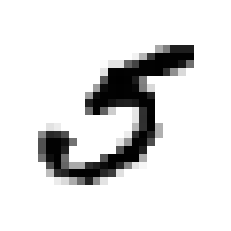

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
#Remodelando uma instancia para um array 28x28
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
#O conjunto de dados MNIST já está separado o conjunto de treinamento do de teste onde as primeiras 60000 sçao treino e as
#útlimas 10000 são de teste
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
#Embaralhando o conjunto de dados (assim nenhum subconjunto fique sem algum digito e evita sensibilidade de alguns algoritmos)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## Classificador Binário
Consegue classificar entre duas classes

### Gradiente Descendente Estocático (SGD)

In [9]:

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## Medidores de Desempenho

### Acurácia

In [11]:
#cross_val_score() para avaliar o modelo SGDClassifier com a validação cruzada K-folds com três partes
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95  , 0.9636, 0.9625])

Acurácia acima de 95%, mas isso pode ser enganoso pois apenas 10% das imagens são o número 5, portando se você adivinhar que uma imagem não é um 5 você estará certo cerca de 90% das vezes

In [12]:
#Reforçando a ideia acima, será testado um Classificador Simples
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90975, 0.9089 , 0.9103 ])

Mais de 90%, ou seja, acurácia para os classificadores geralmente não é a medida de desempenho preferencial

### Matriz de Confusão

Ideia geral é olhar para o número de vezes em que uma classe foi confundida por outra classe

In [13]:
#conjunto de previsões com cross_val_predict que ao invez do cross_val_score que retorna as pontuações da validação,
#cross_val_predict retorna as previsões feitas em cada parte do teste
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
#função para obter a matriz de confusão
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53938,   641],
       [ 1837,  3584]], dtype=int64)

Obs: y_train_5 é a classe alvo e y_train_ped é as classes previstas

Cada linha representa uma classe real e cada coluna uma classe prevista.
Portanto,[0][0] foram classificados como não 5 corretamente(verdadeiros negativos) mas [0][1] foram classificados como 5 errado (falso positivo).
[1][0] foram classificados como não 5 de forma errada (falso negativo) e [1][1] classificados como 5 de forma certa (verdadeiros positivos)

In [15]:
#Para demonstra como seria um classificador perfeito, ter apenas 0 na sua diagonal principal
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [16]:
#Funções para calcular metricas classificadoras como precisão e revocação
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8482840236686391

Quando afirma que uma imagem representa um 5 ele está correto essa porcentagem de vezes

In [17]:
recall_score(y_train_5, y_train_pred)

0.6611326323556539

Mas ele só detecta essa porcentagem dos "5"

In [18]:
#Combinar precisão e revocação em uma única métrica -> pontuação harmônica que é a média harmônica de precisão e revocação
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7431059506531204

## Compensação Precisão/Revocação
Para aumentar/dominuir a precisão ou a revocação é preciso mexer na limiar, aumentando a limiar se tem mais precisão e diminuindo se tem mais revocação, visto que ocorre oposto para um dos dois fatores quando se mexe na limiar.

In [19]:
#em vez de usar o método predict() do classificador se chama decision_function() que faz uma pontuação pra cada instancia
#e em seguida é possível fazer previsões com um limiar definido com base nessas pontuações

y_score = sgd_clf.decision_function([some_digit])
y_score

array([68818.6540433])

In [20]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

True pois a pontuação foi de 188.971 e a limiar escolhida foi 0

In [21]:
threshold = 200000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

False pois a limiar foi aumentada, diminuindo a revocação, isso é bem perceptivel pois some_digit é um 5

### Como decidir qual valor de limiar usar?

In [22]:
#usando cross_val_predict() mas retornando as pontuações das decisões e não das previsões
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

#precision_recall_curve() para calcular a precisão e revocação com todas essas pontuações para todos os limiares
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

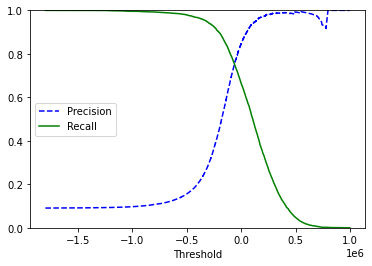

In [23]:
#plotando precisão e revocação em função do valor do limiar
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

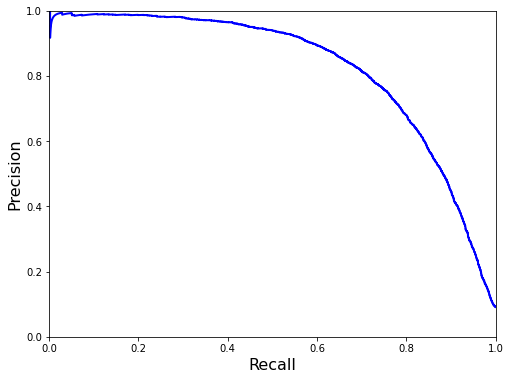

In [24]:
#Para ajudar ainda mais na decisão, é bom plotar o gráfico da precisão vs revocação
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

Mostra que a curva pode melhorar (ficando mais próxima do canto direito superior)

É possivel perceber que a partir de mais ou menos 80% de revocação da precisão tem uma queda acentuada


Então uma boa escolha provavelmente seja em torno de 60% de revocação, mas isso dependerá do que sera mais importante no projeto, revocação ou precisão.

In [25]:
#Por exemplo, se você quer 90% de precisão então provavelmente escolhera um limiar de 70mil
y_train_pred_90 = (y_scores > 70000)

recall_score(y_train_5, y_train_pred_90)

0.5613355469470578

In [26]:
precision_score(y_train_5, y_train_pred_90)


0.9176718938480096

#### Usando a curva ROC

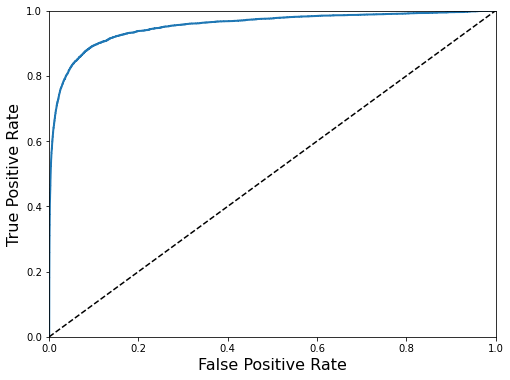

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()


Da pra notar que quanto maior a revocação, maior são os falsos positivos (aqueles classificados como verdadeiros mas que não são)

Um bom classificador tem a curva o mais longe possivel da linha pontilhada (ROC)

In [28]:
#Para medir um bom classificador então, uma opção seria medir a área em baixo da curva, porntanto próximo de 1 seria muito bom
#longe seria um classificador puramente aleatório
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9538696396176168

#### Modelo RandomForestClassifier
Para comparar com o classificador usado anteriormente, esse ão possui um decision_function() mas possui um predict_proba() que retornna a probalidade de uma instancia ser de certa classe, então cada linha do array representa uma instancia e cada coluna uma classe

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba", pre_dispatch=30)


Utilizando a probabildade da classe positiva "[:,1]" como pontuação 

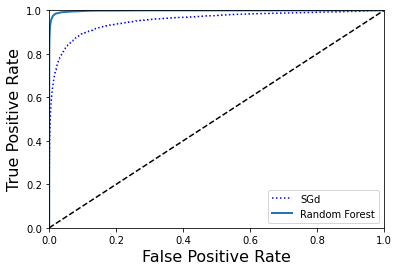

In [30]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGd")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

A curva esta mais encostada ao canto esquerdo superior, consequentemente a pontuação ROC AUC é maior

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984019110052642

## Classificador Multiclasse

O Scikit-Learn detecta quando tenta-se usar um classificador binario em um conjunto de dados com multiplas classes. Nesse caso, ele executa o OvA (um contra todos que seria rodar um classificador binario para cada classe).
Obs: É executado o OvO para classificadores SVM, que seria um contra um que seria um classificador binario para cada par de classe.

In [32]:
#Usando o SGDClassifier para exemplificar o que foi dito acima
sgd_clf.fit(X_train, y_train) #treinando o SGD no conjunto de treinamento X_train com as classes y_train e não y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=int8)

O SkLearn treinou 10 classificadores binarios, obteve sua pontuação por decisão para a imagem e então pegou a classe com maior pontuação

In [40]:
#metodo decision_function() irá mostrar as 10 pontuações por instancia
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-353973.37303443, -410156.16160012, -263987.71194561,
          22355.14854924, -424087.69507802,    9847.76444068,
        -831991.39290157, -453819.88988279, -566805.19145927,
        -739181.1521009 ]])

In [41]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

#### RandomForestClassifier

In [42]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

O classificador multiclasse deu a resposta certa

In [43]:
forest_clf.predict_proba([some_digit])

array([[0.02, 0.  , 0.02, 0.11, 0.  , 0.8 , 0.  , 0.  , 0.03, 0.02]])

In [44]:
#cross_val_score() para avaliar a precisão do classificador
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85295, 0.8818 , 0.86615])

In [45]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9641 , 0.96495, 0.9683 ])

É possível aumentar a precisão, dimensionando as entradas

## Análise de Erro

### Matriz de Confusão

In [47]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [48]:
conf_mx

array([[5504,    1,   63,   22,    6,   34,   32,   30,  200,   31],
       [   0, 6190,   47,   54,    7,   33,    9,   15,  363,   24],
       [  21,   88, 5068,  202,   49,   29,   54,   75,  326,   46],
       [  16,   23,  182, 5157,   10,  178,   16,   60,  344,  145],
       [  13,   20,   54,   22, 4991,   10,   36,   68,  233,  395],
       [  54,   19,   74,  313,   54, 3982,   95,   54,  561,  215],
       [  30,   40,   93,   12,   34,   75, 5461,   19,  144,   10],
       [  13,   14,   53,   41,   44,    6,    5, 5643,  111,  335],
       [  23,  106,   70,  209,   42,  163,   44,   29, 4993,  172],
       [  22,   17,   22,   70,  112,   53,    0,  326,  298, 5029]],
      dtype=int64)

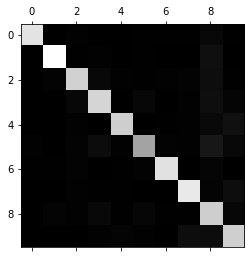

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Maioria das imagens está na diagonal mas da para perceber que alguns quadrados na diagonal estão mais cinzas do que brancos

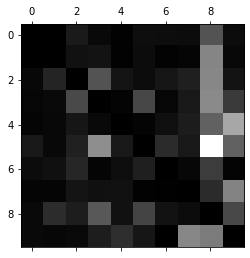

In [53]:
#Plotando os erros
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

#Preenchendo a diagonal com 0 para plotar apenas os erros
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


Lembrando que as linhas representam as classes reais e as colunas as classes com que foram confundidas, é notavel por exemplo que o 5 é muito confundido com 8

Obtendo informações de porque o classificador está falhando em alguns casos

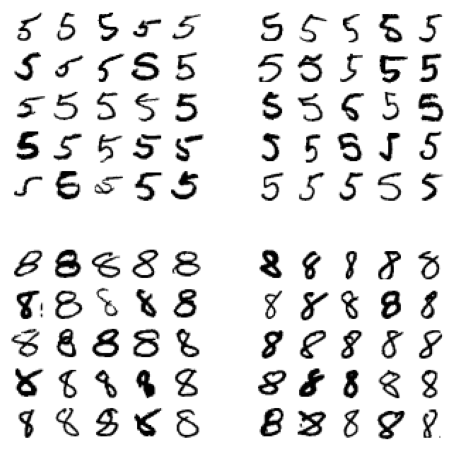

In [58]:
import matplotlib as mpl

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Primeiros dois blocos a esquerda mostram imagens classificadas como 5  e os dois a esquerda como 8.
Alguns erros são muito perceptiveis para nós entendermos poruqe o classificador cometeu. A razão disso é por utilizar um classificador simples que é um modelo linear, como 5 e 8 diferem em alguns pixels esse modelo facilmente confundira essas classes pois o classificador atribiu um peso por classe a cada pixel.

### Classificação Multilabe

É atribiur uma instancia para mais de um classe

In [60]:
from sklearn.neighbors import KNeighborsClassifier

#Se é maior que 7 e impar
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

### Classificação Multioutput
Um rótulo pode assumir mais de dois vallores, seria uma espécie de regressão


In [62]:
#Coloando ruino nas imagens do conjunto de dados
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [65]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
